In [1]:
'''
__author__ = 'Alex Cheng'
Python集成方法工具包解决分类问题：梯度提升法 处理玻璃多分类 数据不平衡 问题
ensemble: RandomForestClassifier,
回归：分割点质量是有平方误差和（mse）
分类：误分类指标，ROC曲线，误分类率
predict,predic_proba,predict_log_proba

梯度提升算法会过拟合，持续跟踪AUC最佳值，其最佳值生成ROC曲线，fpr,tpr等
决策树数目的增加就等同于在梯度下降中采取了更多步骤，每一步就意味着又训练了一个决策树

'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import datasets,linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve,auc,roc_auc_score,mean_squared_error, \
accuracy_score,confusion_matrix
from math import sqrt
import random

In [2]:
path = 'd:/input/jobs/'
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/"
             "glass/glass.data")
df = pd.read_csv(target_url,header=None,prefix="V")
#df = pd.read_csv(target_url)
df.head()
glassNames = np.array(['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type'])

In [3]:
# 原始数组
xList  = np.array(df.iloc[:,1:-1]) # 属性数组,第一列是标号没有意义
#labels = [i for i in df.iloc[:,-1]] # 最后一列就是label
nrows = len(xList)
ncols = len(xList[0])

# 标签是整数值，转换成连续整数
labels = df.iloc[:,-1]
labelList = list(set(labels))
labelList.sort() # 原地排序
newLabels = []
for i in labels:
    newLabels.append(labelList.index(i))
#print(labels[:5],newLabels[:5])

labelCode = {}
for k,v in zip(labelList,range(len(labelList))):
    labelCode[k] = v
#print(labelCode)
labels.value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: V10, dtype: int64

In [9]:
# 样本类别分布不均匀，分层抽样（stratified sampling）30%
# 初始化，先去一种类型
xTrainTemp = [xList[i] for i in range(nrows) if newLabels[i] == 0] # 0类型
yTrainTemp = [newLabels[i] for i in range(nrows) if newLabels[i] == 0]
xTrain,xTest,yTrain,yTest = train_test_split(xTrainTemp,yTrainTemp,test_size=0.30,random_state=828 ) # 列表格式
#print(len(xTrain),len(yTrain))
for label in range(1,len(labelList)):
    xTemp = [xList[i] for i in range(nrows) if newLabels[i] == label] # 其它类型也分层抽样
    yTemp = [newLabels[i] for i in range(nrows) if newLabels[i] == label]
    xTrainTemp,xTestTemp,yTrainTemp,yTestTemp = train_test_split(xTemp,yTemp,test_size=0.30,random_state=828)
    
    xTrain = np.append(xTrain,xTrainTemp,axis=0)
    xTest = np.append(xTest,xTestTemp,axis=0)
    yTrain = np.append(yTrain,yTrainTemp,axis=0)
    yTest = np.append(yTest,yTestTemp,axis=0)


# Gradient Boosting 
#nEst = range(50,5000,50) # 梯度提升自动会依次增加
nEst = 500
depth = 3 # 梯度提升无需太深，除非属性之间有较大的关系
maxFeat = 4 # 随机森林作为基学习器
subSamp = 0.5
lr = 0.003

glassGB = ensemble.GradientBoostingClassifier(n_estimators=nEst,max_depth=depth,
                learning_rate=lr,max_features=maxFeat,subsample=subSamp)
glassGB.fit(xTrain,yTrain)

# 
error = []
missBest = 1.0
pred = glassGB.staged_decision_function(xTest) # 迭代生成器
for p in pred: # p是多分类
    miss = 0 # 每轮
    for i in range(len(p)):
        listP = p[i].tolist()
        #print(listP)
        if listP.index(max(listP)) != yTest[i]: # 每个分类的概率，取最大的
            miss +=1
    miss = float(miss)/len(p) # 注意要float，否则可以异常数值
    error.append(miss) # 错误率在（0,1）
    #error.append(float(miss)/len(p))
    
    # 哪一轮最佳
    if miss <missBest: # 这里miss必须是miss/len(p)
        missBest = miss # 最小错误
        pBest = p #用于后续混淆矩阵,注意p是多维的

idxBest = error.index(min(error)) # 最佳的提升树数量
#print(pred[:5]) # pred是generator
print('Best miss Error: ',missBest)
print('Best number of Gradient Boosting tree: ',idxBest)


Best miss Error:  0.3333333333333333
Best number of Gradient Boosting tree:  372


In [5]:
p[:5]

array([[-0.82184546, -1.80312275, -2.47058413, -4.01754561, -4.40185948,
        -1.22339597],
       [-0.04023463, -1.47019896, -3.51217759, -4.05601577, -4.48448866,
        -3.34735417],
       [ 0.12523523, -1.71534034, -3.16889083, -3.98087019, -4.48482412,
        -3.34693229],
       [-0.8426281 , -1.07174374, -3.32742557, -4.04206879, -4.48499122,
        -3.35030749],
       [-0.50748029, -1.82675199, -2.71793562, -4.01976073, -4.36292931,
        -3.30119668]])

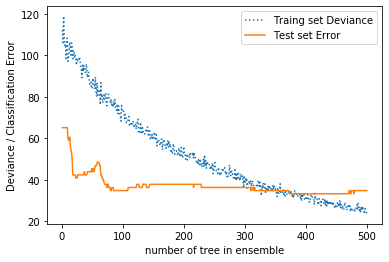

In [10]:
# 绘制训练deviance和ceshi1的auc vs number of trees
error = [100 * er for er in error] #(0,1)为了和训练集的deviance比较
plt.figure()
plt.plot(range(1,nEst+1),glassGB.train_score_,label='Traing set Deviance',linestyle=":")
plt.plot(range(1,nEst+1),error, label='Test set Error')
plt.legend(loc='upper right')
plt.xlabel('number of tree in ensemble')
plt.ylabel('Deviance / Classification Error')
plt.show()

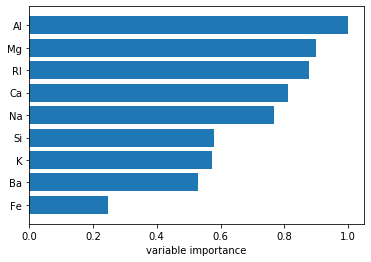

In [7]:
featImportance = glassGB.feature_importances_
featImportance = featImportance / featImportance.max()
#print(len(featImportance))
idxSorted = np.argsort(featImportance) # 后面最大60-40个
barPos = np.arange(idxSorted.shape[0]) + .5
plt.barh(barPos,featImportance[idxSorted], align='center') # 水平柱状图
plt.yticks(barPos, glassNames[idxSorted]) # np.array的数组可以[]取值
plt.xlabel('variable importance')
#plt.subplots_adjust(left=0.2,right=0.9,top=0.9,bottom=0.1)
plt.show()
# 条状图中有些属性对性能的贡献是相当有些的，这不同寻常，在很多情况下，属性的重要性
# 经过前几个后会迅速下降，但是对玻璃分类，有几个属性具有相同的重要性

In [8]:
# 混淆举证，注意pBest是对应多分类的多维
pBestList = pBest.tolist()
Best = [r.index(max(r)) for r in pBestList] # 每行最大值对应的索引
confMat = confusion_matrix(yTest,Best) #Best是列表

print('Confusion Matrix: \n',confMat)

Confusion Matrix: 
 [[21  0  0  0  0  0]
 [ 5 18  0  0  0  0]
 [ 4  2  0  0  0  0]
 [ 0  2  0  1  0  1]
 [ 0  1  0  0  2  0]
 [ 1  1  0  0  0  7]]
